------------------------------------------------------------------------------------------
| | |
|:----------|:----------|
| Name      | Bayesian Modeling |
| Notebook  |  Posterior Predictive distribution|
| Notes | Ad Example: Number of clicks in an ad campaign| 
| Author    | Joshuah Touyz, PhD |
| Version   | 0.1 |
|Last update| 05/29/20 |
-------------------------------------------------------------------------------------------

In [1]:
# Import librarires
import numpy as np
import pandas as pd
import plotnine as pn
import scipy as sp

# Plot configurations
pn.options.figure_size = (10,2)
pn.options.dpi = 125# Import librarires

- We have the analytic form of the posterior and posterior predictive distribution 
- We will show both simulation and direct ways for calculating the posterior predictive distribution
- For the indirect method we will go through the example from begining to end

In [2]:
##########################################
#    Indirect posterior distribution     #
##########################################

# Constants
alpha = 10
beta = 2
Xs = np.array([8,6,10])#sp.random.negative_binomial(n = 34, p = 5/6, size = 100)
size = 100000
sp.random.seed(1234)

# Prior distribution
prior_gamma = lambda alpha, beta, size: sp.random.gamma(shape = alpha, scale = 1/beta, size = size)

# Likelihood
likelihood = lambda x, lambda_in : np.array( [np.prod(sp.stats.poisson.pmf(k = x, mu = i)) for i in lambda_in])

                                   

In [3]:
# Posterior distribution - indirect
lambdas = prior_gamma(alpha,beta,size); lambdas.sort()
lambdas = np.round(lambdas, 1)
lambdas, counts = np.unique(lambdas, return_counts = True)
pi_lambda = counts/size

x_given_lambda = likelihood(Xs,lambda_in = lambdas)

normalizing_constant = np.sum(x_given_lambda * pi_lambda)
posterior_indirect =  pi_lambda * x_given_lambda/normalizing_constant  

In [4]:
# Posterior distribution - direct
# Note: that we need to normalize the pdf here so that it sums to 1
alpha_prime = alpha + np.sum(Xs)
beta_prime = (beta + len(Xs))
posterior_direct = sp.stats.gamma.pdf(x = lambdas, 
                                      a = alpha_prime,
                                      scale = 1/beta_prime)
posterior_direct = posterior_direct/np.sum(posterior_direct) #<- added in here so that posterior_direct sums to 1

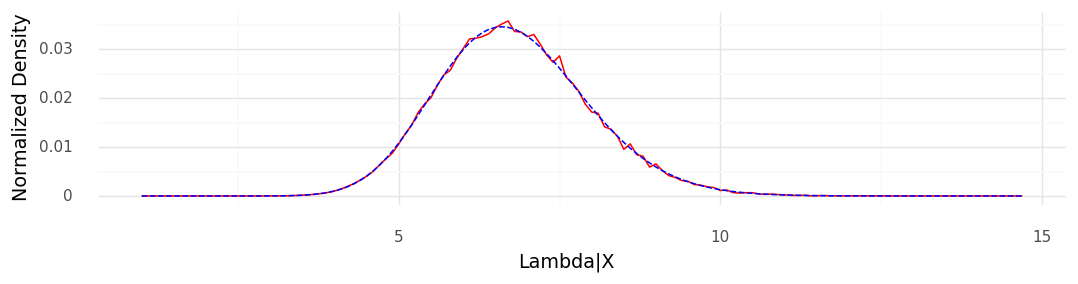

<ggplot: (-9223372036535152254)>

In [5]:
# Setup dataframe and plot the results for both
df_posteriors = pd.DataFrame({'lambdas':lambdas, 
                              'posterior_indirect':posterior_indirect,
                              'posterior_direct':posterior_direct})
pn.ggplot(data = df_posteriors)\
+pn.geom_line(pn.aes(x = 'lambdas', y= 'posterior_indirect'), color = 'red')\
+pn.geom_line(pn.aes(x = 'lambdas', y= 'posterior_direct'), color = 'blue', linetype = 'dashed')\
+pn.xlab('Lambda|X')\
+pn.ylab('Normalized Density')\
+pn.theme_minimal()


In [6]:
##### Posterior predictive through simulation ####
size = 20
X_new = np.arange(0,size,1) 

# Let's generate new values from the posterior, we'll do this directly
lambdas_post = np.arange(0.01,10,0.01)

In [7]:

# Calculating the posterior probs
pr_lambdas_post = sp.stats.gamma.pdf(x = lambdas_post, a = alpha_prime, scale = 1/beta_prime)
pr_lambdas_post = pr_lambdas_post/pr_lambdas_post.sum()

# Updating our likelihood
likelihood_post = lambda X_new: sp.stats.poisson.pmf(k = X_new, mu = lambdas_post)

# Posterior predictive (indirect) 
# --> We take the integral (sum) of the posterior and likelihood
posterior_predictive_indirect = lambda X_new: np.sum(likelihood_post(X_new) * pr_lambdas_post)
ppd_indirect_vals = np.array([posterior_predictive_indirect(i) for i in X_new])

# Posterior predictive direct
ppd_direct_vals = sp.stats.nbinom.pmf(k = X_new, n = alpha_prime, p = (beta_prime/(beta_prime + 1)))

In [8]:
# Setup dataframe and plot the results for both
df_posterior_predictive = pd.DataFrame({'X_new':X_new, 
                              'Posterior Predictive Direct':ppd_direct_vals,
                              'Posterior Predictive Indirect':ppd_indirect_vals})

# Reformatting data frame
df_posterior_predictive = df_posterior_predictive.set_index('X_new').stack().to_frame().reset_index().rename({'level_1':'Method',0:'Probability'},axis=1)
df_posterior_predictive.head()

,X_new,Method,Probability
0,0,Posterior Predictive Direct,0.002032
1,0,Posterior Predictive Indirect,0.002046
2,1,Posterior Predictive Direct,0.011512
3,1,Posterior Predictive Indirect,0.011592
4,2,Posterior Predictive Direct,0.033578


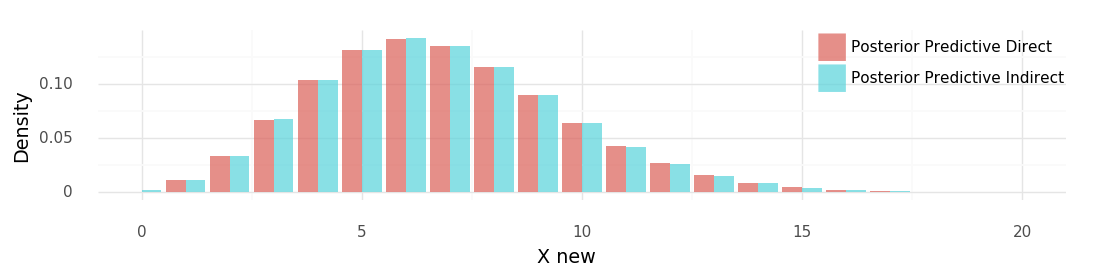

<ggplot: (-9223372036532909596)>

In [9]:
# Potting the densitites
pn.ggplot(pn.aes(x = 'X_new', y = 'Probability', fill = 'Method'), data = df_posterior_predictive)\
+pn.geom_bar(stat = 'identity', alpha = 0.7, position = 'dodge')\
+pn.xlab('X new')\
+pn.ylab('Density')\
+pn.theme_minimal()\
+pn.theme(subplots_adjust={'bottom': 0.2})\
+pn.theme(legend_position=(0.8, .75), legend_title=pn.element_blank()) \
+pn.xlim(0,20)

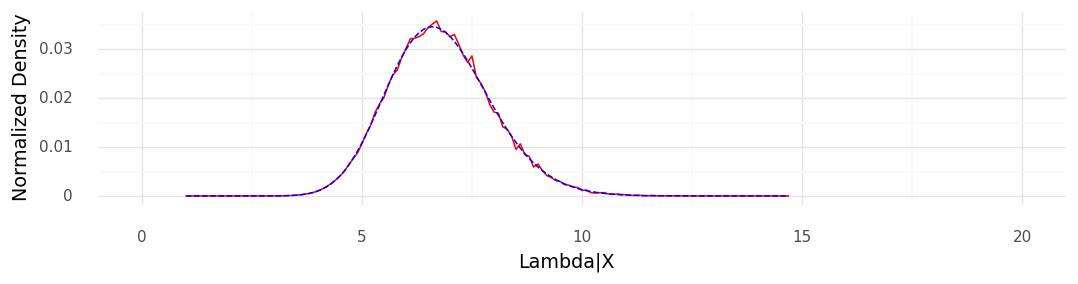

<ggplot: (-9223372036532904823)>

In [10]:
# Compare this to the posterior distribution
pn.ggplot(data = df_posteriors)\
+pn.geom_line(pn.aes(x = 'lambdas', y= 'posterior_indirect'), color = 'red')\
+pn.geom_line(pn.aes(x = 'lambdas', y= 'posterior_direct'), color = 'blue', linetype = 'dashed')\
+pn.xlab('Lambda|X')\
+pn.ylab('Normalized Density')\
+pn.theme_minimal()\
+pn.xlim(0,20)